In [1]:
%gui qt6

# Qt6 stuff
from PyQt6.QtWidgets import QApplication
from PyQt6 import QtWidgets
from PyQt6 import QtGui
from PyQt6 import QtCore
from PyQt6.QtCore import pyqtSignal

# Plotting stuff
import pyqtgraph as pg
import matplotlib.pyplot as plt
import cmasher as cmr

# Science stuff
import numpy as np
import pandas as pd
from spectres import spectres

# Astropy stuff
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.units.quantity import Quantity
from astropy.io.ascii import read as ascii_read


# General stuff
import logging
import sys
from pathlib import Path
from itertools import cycle

# zHunter stuff
from zhunter.initialize import DIRS
from zhunter import io
from zhunter.misc import set_up_linked_vb, get_vb_containing
from zhunter.colors import get_gradient
from zhunter.spectroscopic_system import SpecSystemModel, SpecSystem
from zhunter.MainGraphicsWidget import MainGraphicsWidget
from zhunter.data_handler import DataHandler
from zhunter import __ROOT_DIR__ as ROOT_DIR

# astropalmerio stuff
import astropalmerio.io as io
import astropalmerio.spectra as sp
import astropalmerio.galaxies as gal
import astropalmerio.mc as mc
from astropalmerio.spectra import ergscm2AA
from astropalmerio.spectra import EmissionLine
from specutils import Spectrum1D

from zhunter.colors import COLORS
color_style = 'kraken9'
colors = COLORS[color_style]

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
    format="%(asctime)s.%(msecs)03d | %(levelname)-8s | %(funcName)s - %(filename)s:%(lineno)d : %(message)s",

                   )
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

In [6]:
import numpy as np
flux = np.arange(10)
n = flux.shape[0]
flux_med = np.zeros(n)
window_size = 1
for i in range(window_size, n-window_size):
    flux_med[i] = np.median(flux[i-window_size:i+window_size])
print(flux_med)

[0.  0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 0. ]


In [17]:
from scipy.signal import convolve
from scipy.signal.windows import boxcar

In [ ]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)

In [29]:
n = 10
y2 = convolve(y, boxcar(n), mode='same')/n

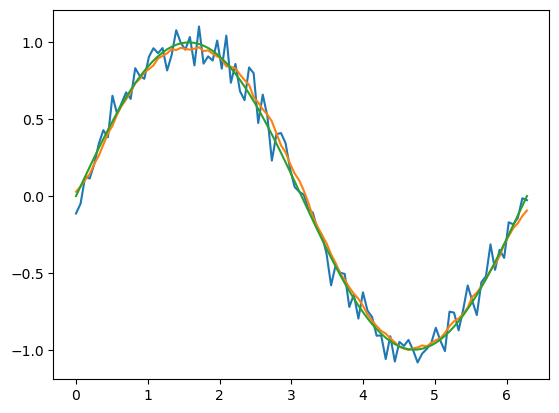

In [31]:
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.plot(x,y2)
plt.plot(x,np.sin(x))

In [28]:
fname = '/Users/palmerio/Downloads/net.fits'
wave, spat, flux, unc = io.read_fits_2D_spectrum(fname)

NameError: name 'io' is not defined

In [5]:
def rebin_spectrum_2d(spectrum, binning_factors, uncertainty=None):
    """
    Rebin a 2D spectrum with optional error propagation.

    Parameters
    ----------
    spectrum : numpy.ndarray
        The input 2D spectrum to be rebinned.

    binning_factors : tuple of int
        A tuple of two integers (binning_factor_x, binning_factor_y) representing the binning factors
        for the x and y dimensions, respectively. Each binning factor must be greater than or equal to 1.

    uncertainty : numpy.ndarray, optional
        The 2D array of uncertainty associated with the input spectrum. If provided, uncertainty will be propagated
        in the rebinned spectrum. Must have the same dimensions as the input spectrum.

    Returns
    -------
    rebinned_spectrum : numpy.ndarray
        The rebinned 2D spectrum.

    rebinned_uncertainty : numpy.ndarray, optional
        The rebinned uncertainty, only returned if uncertainty are provided.

    Example
    -------
    >>> spectrum = np.array([[1, 2, 3, 4],
                             [5, 6, 7, 8],
                             [9, 10, 11, 12],
                             [13, 14, 15, 16]])
    >>> binning_factors = (2, 2)
    >>> uncertainty = np.array([[0.5, 0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5, 0.5]])
    >>> rebinned_spectrum, rebinned_uncertainty = rebin_spectrum_2d(spectrum, binning_factors, uncertainty)
    >>> print(rebinned_spectrum)
    [[14 22]
     [46 54]]
    >>> print(rebinned_uncertainty)
    [[1. 1.]
     [1. 1.]]
    """

    # Check that the input spectrum is a 2D numpy array
    if not isinstance(spectrum, np.ndarray) or spectrum.ndim != 2:
        raise ValueError("Input spectrum must be a 2D numpy array")

    if uncertainty is not None and not isinstance(uncertainty, np.ndarray):
        raise TypeError("Input uncertainty must be a numpy.ndarray, if provided.")

    if uncertainty is not None and spectrum.shape != uncertainty.shape:
        raise ValueError("Spectrum and uncertainty must have the same dimensions.")

    if (
        not isinstance(binning_factors, (list, tuple))
        or len(binning_factors) != 2
        or not all(isinstance(b, int) and b >= 1 for b in binning_factors)
    ):
        raise ValueError(
            "Binning factors must be a list or tuple of two integers greater than or equal to 1."
        )

    # Truncate input spectrum to fit the binning factors
    truncated_spectrum = spectrum[
        : (spectrum.shape[0] // binning_factors[0]) * binning_factors[0],
        : (spectrum.shape[1] // binning_factors[1]) * binning_factors[1],
    ]

    # Reshape the truncated spectrum
    reshaped_spectrum = truncated_spectrum.reshape(
        spectrum.shape[0] // binning_factors[0],
        binning_factors[0],
        spectrum.shape[1] // binning_factors[1],
        -1,
    )

    # Calculate rebinned spectrum using np.nansum
    rebinned_spectrum = np.nansum(reshaped_spectrum, axis=(1, 3))
    if uncertainty is not None:
        # Truncate and reshape uncertainty in the same way as the input spectrum
        truncated_uncertainty = uncertainty[
            : (uncertainty.shape[0] // binning_factors[0]) * binning_factors[0],
            : (uncertainty.shape[1] // binning_factors[1]) * binning_factors[1],
        ]

        reshaped_uncertainty = truncated_uncertainty.reshape(
            uncertainty.shape[0] // binning_factors[0],
            binning_factors[0],
            uncertainty.shape[1] // binning_factors[1],
            -1,
        )

        # Calculate rebinned uncertainty using np.nansum
        rebinned_uncertainty = np.sqrt(np.nansum(reshaped_uncertainty**2, axis=(1, 3)))
        return rebinned_spectrum, rebinned_uncertainty
    else:
        return rebinned_spectrum

In [17]:
hdul = fits.open(fname)
hdul.info()

Filename: /Users/palmerio/Downloads/net.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     182   (2048, 61)   float32   


In [8]:
from astropy.visualization import imshow_norm, ZScaleInterval

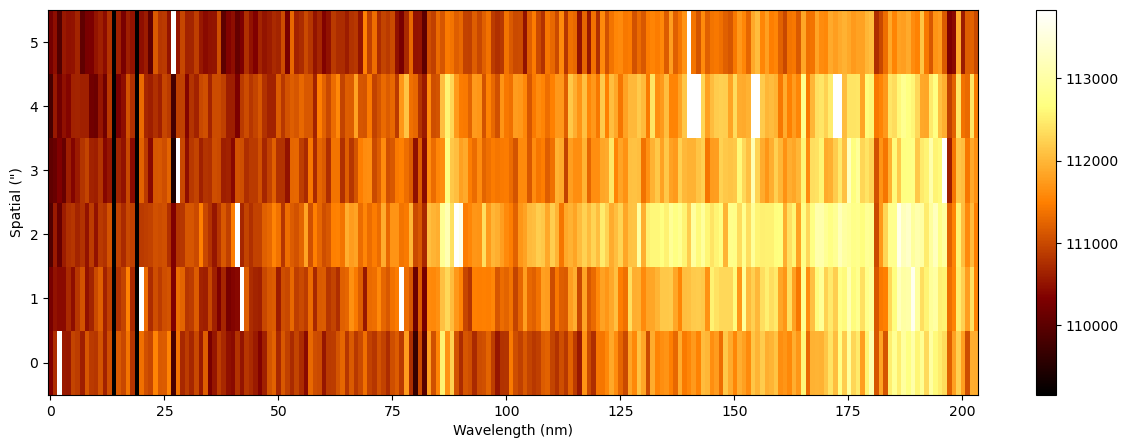

In [20]:
flux_rebin = rebin_spectrum_2d(flux, binning_factors=(10,10))

fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux_rebin, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
#                        extent=[
#                            spec_mid[0],
#                            spec_mid[-1],
#                            spat_mid[0],
#                            spat_mid[-1],
#                        ],
                       cmap='afmhot',
                       interpolation='none',
                      )

plt.colorbar(im)
ax = plt.gca()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')

plt.show()

In [22]:
from zhunter import io


In [23]:
fname2 = '/Users/palmerio/Downloads/GRB230506C_final_1D.txt'
wave, flux, unc = io.read_generic_1D_spectrum(fname2)

2023-11-17 15:40:07,262.262 | INFO     | read_generic_1D_spectrum - io.py:146 : Attempting to read file:
/Users/palmerio/Downloads/GRB230506C_final_1D.txt
2023-11-17 15:40:07,263.263 | DEBUG    | read_generic_1D_spectrum - io.py:165 : Reading with pandas read_csv function
2023-11-17 15:40:07,268.268 | DEBUG    | read_generic_1D_spectrum - io.py:179 : Could not read file with ',' separator, trying others...
2023-11-17 15:40:07,274.274 | DEBUG    | read_generic_1D_spectrum - io.py:189 : Found the following columns: ['4100.0', '-1.9121367040345687E-6', '0.0']
2023-11-17 15:40:07,275.275 | DEBUG    | find_column_name - io.py:821 : Did not find any name matching ['WAVE', 'AWAV', 'WVLG', 'LAM'] in ['4100.0', '-1.9121367040345687E-6', '0.0']
2023-11-17 15:40:07,276.276 | DEBUG    | find_column_name - io.py:821 : Did not find any name matching ['FLUX', 'SCI'] in ['4100.0', '-1.9121367040345687E-6', '0.0']
2023-11-17 15:40:07,277.277 | DEBUG    | find_column_name - io.py:821 : Did not find any 

In [76]:
import zhunter.spectral_functions as sf
wave_smooth, flux_smooth, unc_smooth = sf.smooth(wave.value, flux.value, unc.value, smoothing=10)

In [77]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.transforms as transforms

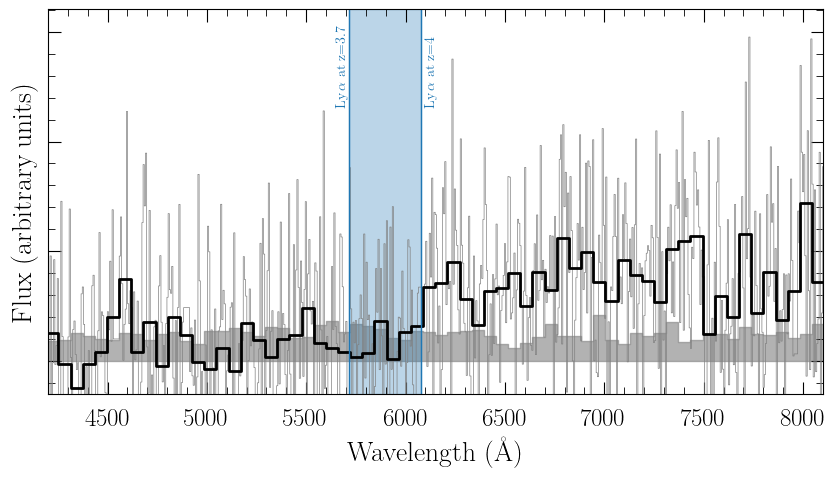

In [124]:
plt.style.use('paper')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(wave, flux, lw=0.5, color='grey', drawstyle='steps-mid')
ax.plot(wave_smooth, flux_smooth, lw=2, color='k', drawstyle='steps-mid')
ax.fill_between(wave_smooth, unc_smooth, lw=1, color='grey', step='mid', alpha=0.6)

trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)
offsets = [-65, 20]
for i, z in enumerate((3.7, 4)):
    lam0 = 1215.67 # AA
    lam_obs = lam0*(1.+z)
    ax.axvline(lam_obs, lw=1)
    offset = offsets[i]
    ax.annotate(r'Ly$\,\alpha$ at '+f'z={z}', xy=(lam_obs+offset, 0.75), xycoords=trans, rotation=90, color='C0')

ax.axvspan(lam0*(1+3.7), lam0*(1+4), color='C0', alpha=0.3)
ax.set_ylim(-1.5e-5)
ax.set_xlim(4200, 8100)
ax.set_xlabel(r"Wavelength ($\rm \AA$)")
ax.set_ylabel(r"Flux (arbitrary units)")

ax.tick_params(labelleft=None)
plt.show()

In [125]:
fig.savefig('/Users/palmerio/Desktop/GRB230506C_1D.pdf', bbox_inches='tight')

In [1]:
d1 = {'a':3}
d2 = {'a':4, 'b':1}

In [2]:
d1.update(d2)

In [3]:
d1

{'a': 4, 'b': 1}

In [4]:
d2['a'] = 12
d1

{'a': 4, 'b': 1}

In [41]:
import functools

def check_active(func):
    """Check that the widget (passed in self) is active
    before running the function.
    """
    @functools.wraps(func)
    def wrapper_check_active(self, *args, **kwargs):
        if self.active:
            func(self, *args, **kwargs)
            return func(self, *args, **kwargs)
        else:
            log.warning(f"Ignoring call to {func.__name__} as {self} is not active.")


    return wrapper_check_active

def debug(func):
    """Print the function signature and return value"""
    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]                      # 1
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]  # 2
        signature = ", ".join(args_repr + kwargs_repr)           # 3
        log.debug(f"Calling {func.__name__}({signature})")
        value = func(*args, **kwargs)
        log.debug(f"{func.__name__!r} returned {value!r}")           # 4
        return value
    return wrapper_debug

In [47]:
class test:
    def __init__(self):
        self.active = False
    
    def __name__(self):
        return "TEST"

    @debug
    @check_active
    def react(self, val):
        log.info(f'Am active, here is your value {val!r}')

In [48]:
t = test()
t

In [49]:
t.react(5)

2023-08-04 18:39:15,157.157 | DEBUG    | wrapper_debug - 320094.py:25 : Calling react(<__main__.test object at 0x18276c850>, 5)
2023-08-04 18:39:15,158.158 | WARNING  | wrapper_check_active - 320094.py:13 : Ignoring call to react as <__main__.test object at 0x18276c850> is not active.
2023-08-04 18:39:15,159.159 | DEBUG    | wrapper_debug - 320094.py:27 : 'react' returned None


In [45]:
t.active = True

In [40]:
t.react(5)

2023-08-04 18:37:53,046.046 | DEBUG    | wrapper_debug - 3942565491.py:24 : Calling react(<__main__.test object at 0x1826ccd00>, 5)
2023-08-04 18:37:53,048.048 | INFO     | react - 3109509914.py:8 : Am active, here is your value 5


TypeError: react() missing 1 required positional argument: 'val'

In [8]:
def get_signals(source):
    cls = source if isinstance(source, type) else type(source)
    signal = type(QtCore.pyqtSignal())
    for subcls in cls.mro():
        clsname = f'{subcls.__module__}.{subcls.__name__}'
        for key, value in sorted(vars(subcls).items()):
            if isinstance(value, signal):
                print(f'{key} [{clsname}]')

In [62]:
spec_mid, spat_mid, flux, unc = generate_fake_2D_spectrum(SNR=1, spec_start=650, emission_line=False)

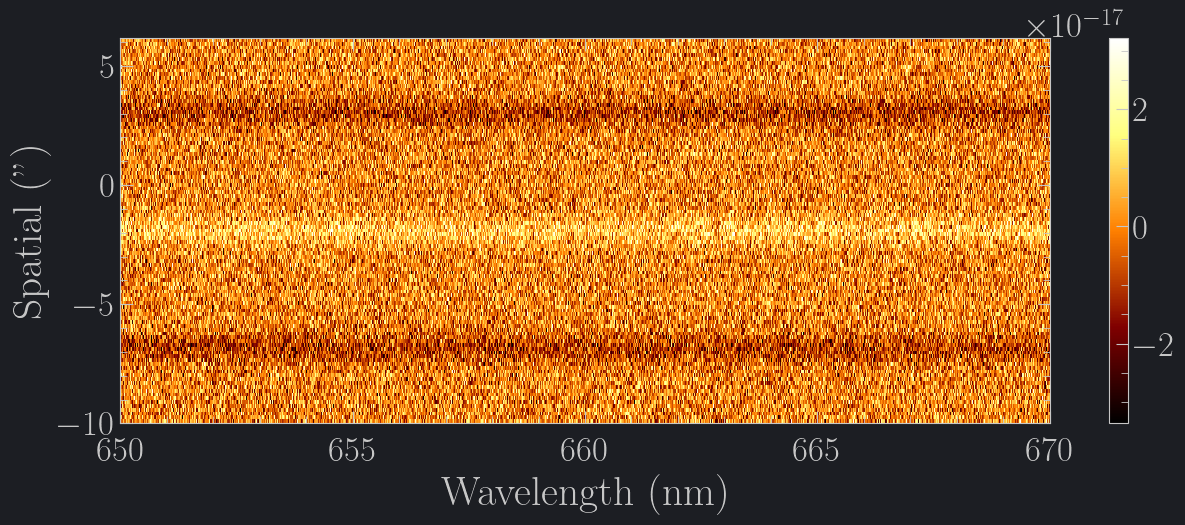

In [63]:
from astropy.visualization import ZScaleInterval, imshow_norm

plt.style.use('kraken')
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           spec_mid[0],
                           spec_mid[-1],
                           spat_mid[0],
                           spat_mid[-1],
                       ],
                       cmap='afmhot',
                       interpolation='none',
                      )

plt.colorbar(im)
ax = plt.gca()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')

plt.show()

In [10]:
import zhunter.gui
from zhunter.gui import MainGUI

gui = MainGUI()
gui.mode = "1D"
fname = Path(
    str(Path(zhunter.gui.__file__).resolve().parents[2])
    + "/dev/data/test_input_files/XSHOOTER_bintable_1D.fits"
)
gui.config["fnames"]["data"] = fname
gui.plot()
gui.add_specsys(z=6.317, sys_type="abs")
gui.show()

2023-06-30 14:13:21,156 DEBUG [zhunter.initialize] Looking for config file
2023-06-30 14:13:21,157 DEBUG [zhunter.initialize] Config file found:
/Users/palmerio/.config/zhunter/default_config.yaml
2023-06-30 14:13:21,160 INFO [zhunter.initialize] Loaded configuration from:
/Users/palmerio/.config/zhunter/default_config.yaml
2023-06-30 14:13:21,162 DEBUG [zhunter.initialize] Reading intervening lines from:
/Users/palmerio/Code_projects/zHunter/src/zhunter/data/lines/intervening_lines.ecsv
2023-06-30 14:13:21,163 DEBUG [zhunter.io] Reading line list:
/Users/palmerio/Code_projects/zHunter/src/zhunter/data/lines/intervening_lines.ecsv
2023-06-30 14:13:21,169 DEBUG [zhunter.initialize] Reading emission lines from:
/Users/palmerio/Code_projects/zHunter/src/zhunter/data/lines/emission_lines.ecsv
2023-06-30 14:13:21,170 DEBUG [zhunter.io] Reading line list:
/Users/palmerio/Code_projects/zHunter/src/zhunter/data/lines/emission_lines.ecsv
2023-06-30 14:13:21,175 DEBUG [zhunter.initialize] Readin

Traceback (most recent call last):
  File "/Users/palmerio/Code_projects/zHunter/src/zhunter/MainGraphicsWidget.py", line 663, in keyPressEvent
    scene_pos = self.mapToScene(self.mousePoint)
TypeError: arguments did not match any overloaded call:
  mapToScene(self, point: QPoint): argument 1 has unexpected type 'QPointF'
  mapToScene(self, rect: QRect): argument 1 has unexpected type 'QPointF'
  mapToScene(self, polygon: QPolygon): argument 1 has unexpected type 'QPointF'
  mapToScene(self, path: QPainterPath): argument 1 has unexpected type 'QPointF'
  mapToScene(self, ax: int, ay: int): argument 1 has unexpected type 'QPointF'
  mapToScene(self, ax: int, ay: int, w: int, h: int): argument 1 has unexpected type 'QPointF'
